## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [27]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def show_img(img, label):
    plt.figure()
    plt.title(label)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img, cmap=None)
    
def read_img(image_path):
    img = cv2.imread(image_path)
    #convert to RGB space from BGR
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def save_img(img, path):
    cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

def to_HLS(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #     H = hls[:,:,0]
    #     L = hls[:,:,1]
    #     S = hls[:,:,2]

def to_greyscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def add_text(img, text):
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,100)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(img, text, bottomLeftCornerOfText, font, fontScale, fontColor, lineType)

test_img1 = read_img('test_images/straight_lines1.jpg')
test_img2 = read_img('test_images/straight_lines2.jpg')
test_img  = [read_img(x) for x in  glob.glob('test_images/test[0-9].jpg')]


## Computing the camera calibration using chessboard images

In [28]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

# computing the distortion matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)



## Use color transforms, gradients, etc., to create a thresholded binary image

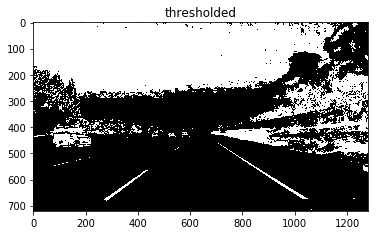

In [29]:

hls = to_HLS(test_img2)

H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

show_img(hls_select(test_img2, thresh = (90, 255)), 'thresholded')

## Apply a distortion correction to raw images

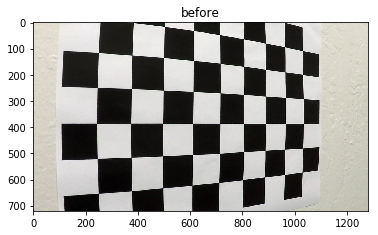

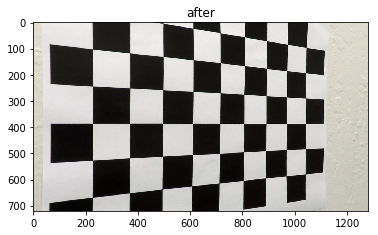

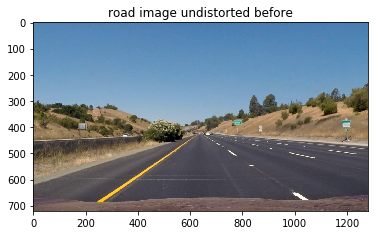

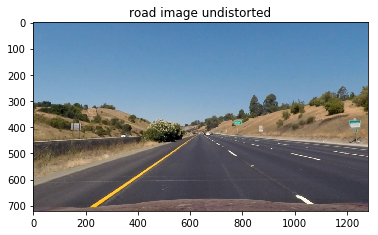

In [40]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
    
test_distortion_input = read_img(images[0])
test_distortion_output = undistort(test_distortion_input)

show_img(test_distortion_input, 'before')
show_img(test_distortion_output, 'after')
show_img(test_img1, 'road image undistorted before')
show_img(undistort(test_img1), "road image undistorted after" )


## Apply a perspective transform to rectify binary image ("birds-eye view").

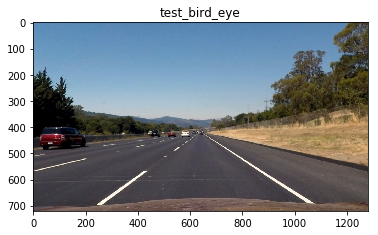

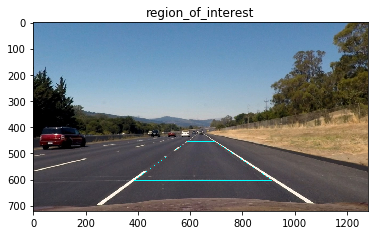

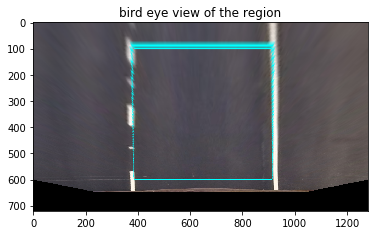

In [33]:
#%matplotlib qt

test_bird_eye = undistort(test_img2)
show_img(test_bird_eye, 'test_bird_eye')

pts_src = np.float32( 
    [
        [589.815, 455.645], 
        [696.734,455.645], 
        [914.606, 603.919],
        [386.065, 603.919]
    ])

pts_dest = np.float32( 
    [
        [386.065, 100], 
        [914.606, 100], 
        [914.606, 600],
        [386.065, 600]
    ])

reg_dest = pts_dest.reshape((-1,1,2))
reg_src = pts_src.reshape((-1,1,2))
region_src = cv2.polylines(test_bird_eye,np.int32([reg_src]),True,(0,255,255))
show_img(region_src, 'region_of_interest')

M = cv2.getPerspectiveTransform(pts_src, pts_dest)
MInv = cv2.getPerspectiveTransform(pts_dest, pts_src)

def to_birdeye(img):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

def from_birdeye(img):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, MInv, img_size, flags=cv2.INTER_LINEAR)


birdeye = to_birdeye(test_bird_eye)
region_dest = cv2.polylines(birdeye,np.int32([reg_dest]),True,(0,255,255))
show_img(region_dest, 'bird eye view of the region')


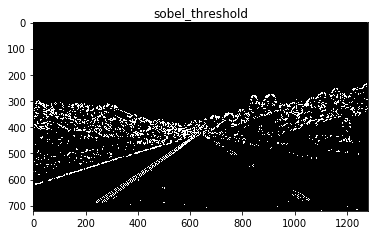

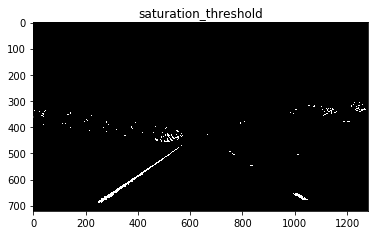

In [34]:
hls = to_HLS(test_img2)

H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

def s_threshold(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    (thresh_min, thresh_max) = thresh
    # Convert to grayscale
    gray = to_greyscale(img)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = to_greyscale(img)

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = to_greyscale(img)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output


# Choose a Sobel kernel size

def threshold_combined(img):
    # Apply each of the thresholding functions
    ksize = 15 # Choose a larger odd number to smooth gradient measurements
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

def sobel_threshold(img):
    return threshold_combined(img)

def saturation_threshold(img): 
    s_thresh = s_threshold(img, thresh=(170, 255))
    return s_thresh

show_img(threshold_combined(test_img1), "sobel_threshold")
show_img(saturation_threshold(test_img1), "saturation_threshold")


## Detect lane pixels and fit to find the lane boundary.

(11084.467430831668, 3497.7957041896002)
2.86832322091


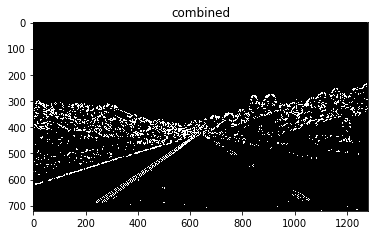

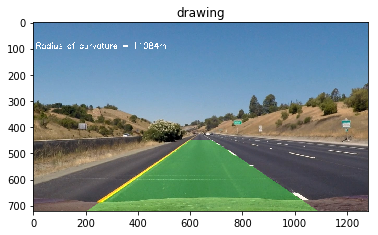

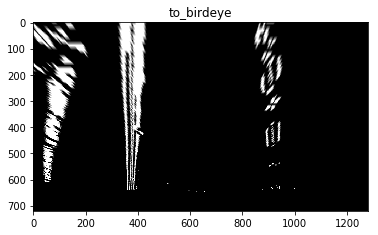

In [35]:

# compute the polynomials defining the left and right lanes
def compute_lanes_poly(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
#         (0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
#         (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    if (leftx.size == 0) or (lefty.size == 0) or (rightx.size == 0) or (righty.size == 0):
        return None
    else :
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        return (left_fit, right_fit)

# # Generate x and y values for plotting
# ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
# plt.imshow(out_img)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)


def compute_next_lanes_poly(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return (left_fitx, right_fitx)


# # Create an image to draw on and an image to show the selection window
# out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# window_img = np.zeros_like(out_img)
# # Color in left and right line pixels
# out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
# out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# # Generate a polygon to illustrate the search window area
# # And recast the x and y points into usable format for cv2.fillPoly()
# left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
# left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
#                               ploty])))])
# left_line_pts = np.hstack((left_line_window1, left_line_window2))
# right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
# right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
#                               ploty])))])
# right_line_pts = np.hstack((right_line_window1, right_line_window2))

# # Draw the lane onto the warped blank image
# cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
# cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
# result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
# plt.imshow(result)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)

def compute_curvature(img, left_fit_cr, right_fit_cr):
    ploty = img.shape[0]
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad)


def draw_area(undist, warped, left_fit, right_fit):
    # Create an image to draw the lines on
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    #newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    newwarp = from_birdeye(color_warp)
    
    # Combine the result with the original image
    img = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    left_curverad, right_curverad = compute_curvature(img, left_fit, right_fit)
    add_text(img, "Radius of curvature = {}m".format(int(left_curverad)))
    return img 

def compute_lane_distance(img, left_fit, right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    Al = left_fit[0]
    Bl = left_fit[1]
    Cl = left_fit[2]
    Ar = right_fit[0]
    Br = right_fit[1]
    Cr = right_fit[2]
    ploty = img.shape[0]
    y_eval = np.max(ploty)

    leftx  = Al*(ploty**2) + Bl*ploty + Cl
    rightx = Ar*(ploty**2) + Br*ploty + Cr
    
    return np.absolute((leftx - rightx)* xm_per_pix)

combined = threshold_combined(test_img1)

show_img(combined, "combined")
bw = to_birdeye(combined)
(left_fit, right_fit) = compute_lanes_poly(bw)

show_img(draw_area(test_img1, bw, left_fit, right_fit), "drawing")


#normal = from_birdeye(birdeye)
region_dest = cv2.polylines(birdeye,np.int32([reg_dest]),True,(0,255,255))
show_img(bw, 'to_birdeye')

print(compute_curvature(test_img1, left_fit, right_fit))
print(compute_lane_distance(test_img1, left_fit, right_fit))


  max_open_warning, RuntimeWarning)



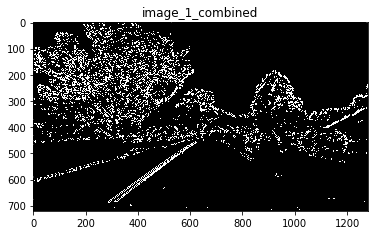

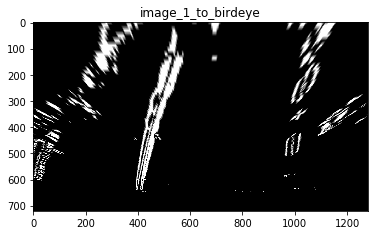

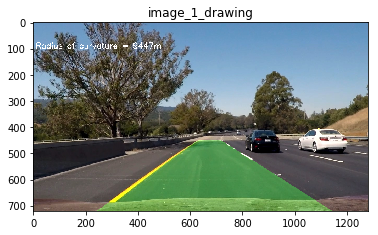

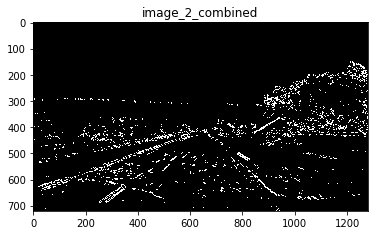

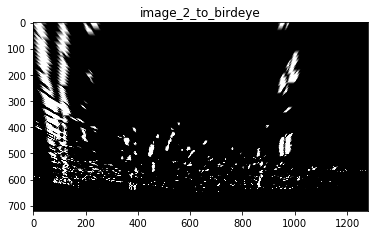

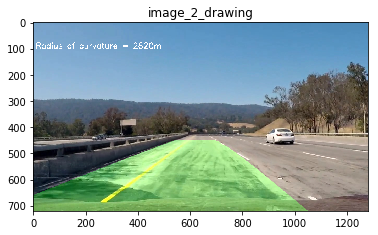

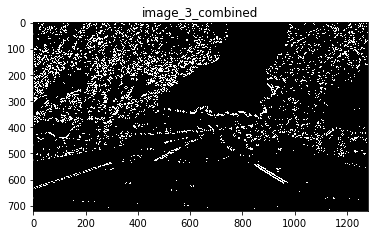

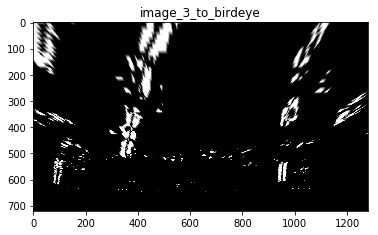

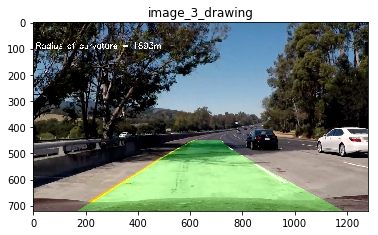

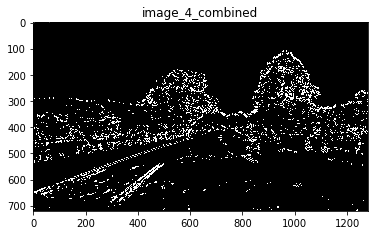

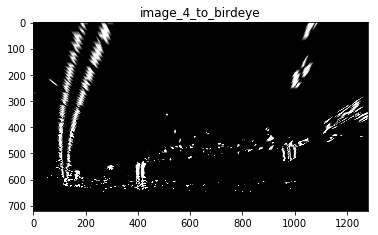

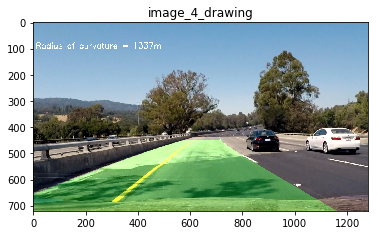

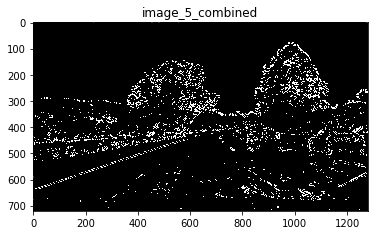

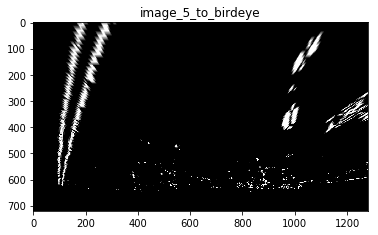

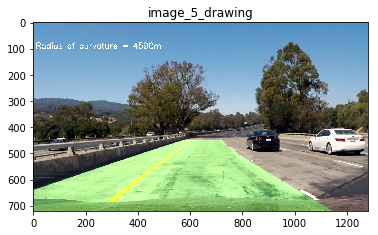

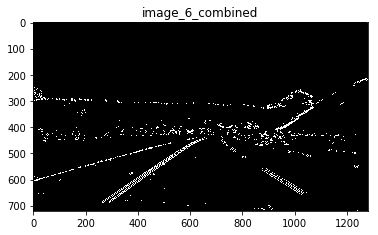

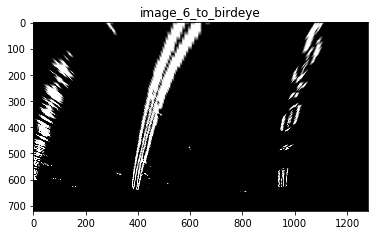

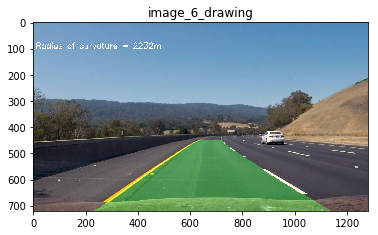

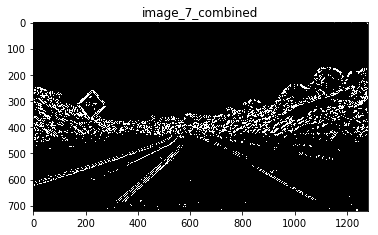

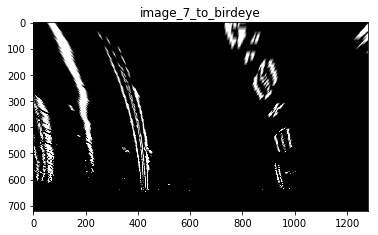

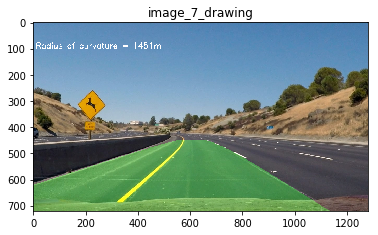

In [36]:
def testing(img, name):
    combined = threshold_combined(img)
    show_img(combined, "{}_combined".format(name))
    bw = to_birdeye(combined)
    show_img(bw, '{}_to_birdeye'.format(name))
    left_fit, right_fit = compute_lanes_poly(bw)
    show_img(draw_area(img, bw, left_fit, right_fit), "{}_drawing".format(name))

img_count = 0
for img in test_img:
    img_count = img_count+1
    #show_img(img, "test")
    testing(img, "image_{}".format(img_count))
    

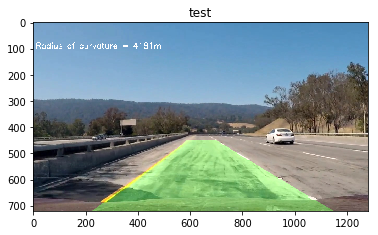

In [38]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import collections

def get_process_image():
    previous_fits = collections.deque(maxlen=10)
    previous = None
    bad_measurements_count = 0 
    lane_distance = 3.3
    lane_distance_del = 0.3
    MAX_BAD_MEASUREMENTS = 10
    
    
    def process_image(img1, threshold_method=sobel_threshold):
        nonlocal previous_fits
        nonlocal bad_measurements_count
        binary1 = threshold_method(img1)
        binary_warped1 = to_birdeye(binary1)
        #print(binary_warped1.shape)
        if len(previous_fits) == 0 or bad_measurements_count > MAX_BAD_MEASUREMENTS :
            line_fit = compute_lanes_poly(binary_warped1)
            if line_fit == None:
                return img1
            else:
                left_fit, right_fit = line_fit
                bad_measurements_count = 0
                previous_fits.clear()
        else:
            prevous_left_fit, previous_right_fit = previous_fits[0] # np.mean(np.array(previous_fits[0]), axis=1)
            left_fit, right_fit = compute_next_lanes_poly(binary_warped1, prevous_left_fit, previous_right_fit)

        distance = compute_lane_distance(img1, left_fit, right_fit)
        if (distance > lane_distance + lane_distance_del) : 
            if len(previous_fits) == 0 and threshold_method == sobel_threshold  :
                return process_image(img1, threshold_method=saturation_threshold)
            elif threshold_method != sobel_threshold:
                return img1
            else :
                #print(distance)
                left_fit, right_fit = prevous_left_fit, previous_right_fit
                bad_measurements_count = bad_measurements_count + 1
        else:
            #left_curverad, right_curverad = compute_curvature(img1, left_fit, right_fit)
            previous_fits.append((left_fit, right_fit))
        return draw_area(img1, binary_warped1, left_fit, right_fit)
    
    return process_image
    
    
show_img(get_process_image()(test_img[1]),"test")

In [39]:
white_output = 'output_images/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
process_image = get_process_image()
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 3min 58s, sys: 45.1 s, total: 4min 43s
Wall time: 4min 1s


 48%|████▊     | 611/1261 [01:58<02:04,  5.20it/s]WARNING:py.warnings:/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:77: RankWarning: Polyfit may be poorly conditioned

 49%|████▊     | 613/1261 [01:59<02:05,  5.15it/s]WARNING:py.warnings:/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:77: RankWarning: Polyfit may be poorly conditioned

100%|█████████▉| 1260/1261 [04:01<00:00,  5.48it/s]
